Skewness: 1.5141797167430497
Skewness: 1.804229505767448
Correlación de las variables expenses y insurance_price_log: 0.9978955573216761
╒══════╤═══════╤════════╤═══════╤══════════╤═══════════╤════════════╤═════════════════════╤═══════════════════╤══════════════╤════════════════╤═══════════════════════╕
│      │   age │ sex    │   bmi │ smoker   │ region    │   expenses │ physical_activity   │   insurance_price │      z_score │   expenses_log │   insurance_price_log │
╞══════╪═══════╪════════╪═══════╪══════════╪═══════════╪════════════╪═════════════════════╪═══════════════════╪══════════════╪════════════════╪═══════════════════════╡
│    0 │    19 │ female │  27.9 │ yes      │ southwest │   16884.9  │ active              │          32884.7  │  0.178154    │        9.73424 │              10.4008  │
├──────┼───────┼────────┼───────┼──────────┼───────────┼────────────┼─────────────────────┼───────────────────┼──────────────┼────────────────┼───────────────────────┤
│    1 │    18 │ male  

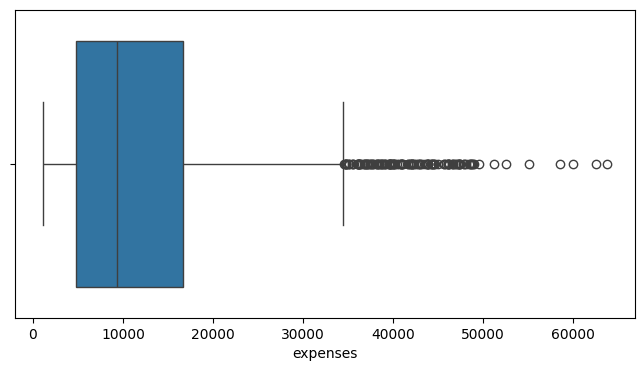

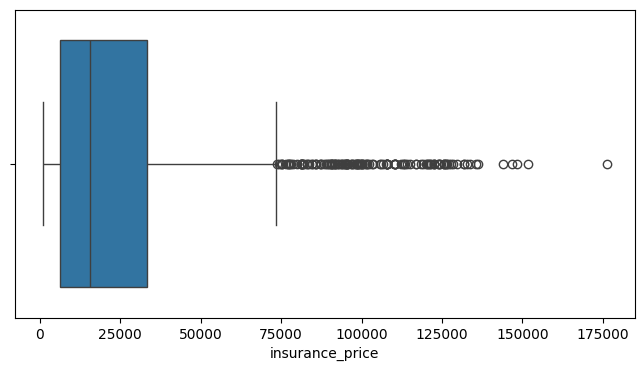

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tabulate import tabulate
from scipy.stats import skew

#1339 filas
df = pd.read_csv('../csvs/insurance.csv')
#.strip() coge todas las columnas en este caso de texto y le quita los espacios en blanco.
df.columns = df.columns.str.strip()
np.random.seed(42)
physical_activity_levels = np.array(["sedentary", "moderate", "active"])
df['physical_activity'] = np.random.choice(physical_activity_levels, size = len(df))

#Eliminamos la columna children dado que carece de relevancia real significativa a la hora de calcular un seguro médico personal.
df = df.drop("children", axis=1)

#Usaremos la columna expenses (gastos médicos en el último año), dividiéndolo en deciles para aplicarle un incremento dependiendo del decil correspondiente para usarlo como precio base
decil = pd.qcut(df['expenses'], q=10, labels=False)
expenses = df['expenses']
incremento = 1 + (decil * 0.10)
precio_base = expenses * incremento
df['insurance_price'] = precio_base

plt.figure(figsize=(8,4))
sns.boxplot(x=df['expenses'])
#plt.show()
df['z_score'] = zscore(df['expenses'])
outliers = df[df['z_score'].abs() > 3]

#print("Valores atípicos detectados:\n", outliers)
print("Skewness:", skew(df['expenses']))
df['expenses_log'] = np.log1p(df['expenses'])  


"""Q1 = np.percentile(df['expenses'], 25)  # Primer cuartil (Q1)
Q3 = np.percentile(df['expenses'], 75)  # Tercer cuartil (Q3)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
outliers = df[(df['valores'] < limite_inferior) | (df['valores'] > limite_superior)]
print("Outliers encontrados:\n", outliers) """
def ajustar_precio(fila):
    precio = fila['insurance_price']  
    #Edad
    if fila['age'] < 25:
        precio *= 0.90  # 10% de descuento
    elif fila['age'] > 75:
        precio *= 1.25  # 25% de incremento
    elif fila['age'] > 50:
        precio *= 1.10  # 10% de incremento

    #Sexo
    if fila['sex'] == 'female':
        if 18 <= fila['age'] <= 45:
            precio *= 1.07  # 7% de incremento
        elif fila['age'] > 45:
            precio *= 1.02  # 2% de incremento

    #BMI
    if fila['bmi'] < 18.5:
        precio *= 1.02  # 2% de incremento
    elif 25 <= fila['bmi'] < 30:
        precio *= 1.05  # 5% de incremento
    elif fila['bmi'] >= 30:
        precio *= 1.10  # 10% de incremento

    #Smoker
    if fila['smoker'] == 'yes':
        precio *= 1.10  # 10% de incremento

    #Región
    if fila['region'] == 'northeast': # 1% de incremento
        precio *= 1.01
    elif fila['region'] == 'southwest': # 3% de incremento
        precio *= 1.03
    elif fila['region'] == 'southeast': # 2% de incremento
        precio *= 1.02
  
    #Physical activity
    if fila['physical_activity'] == 'sedentary': # 5% de incremento
          precio *= 1.05
    elif fila['physical_activity'] == 'moderate': # 2% de incremento
          precio *= 1.02
  
    return precio

df['insurance_price'] = df.apply(ajustar_precio, axis=1)
plt.figure(figsize=(8,4))
sns.boxplot(x=df['insurance_price'])
df['z_score'] = zscore(df['insurance_price'])
outliers = df[df['z_score'].abs() > 3]

#print("Valores atípicos detectados:\n", outliers)
print("Skewness:", skew(df['insurance_price']))
df['insurance_price_log'] = np.log1p(df['insurance_price']) 
#plt.show()

correlacion = df['expenses_log'].corr(df['insurance_price_log'])
print("Correlación de las variables expenses y insurance_price_log:", correlacion)
print(tabulate(df, headers='keys', tablefmt='fancy_grid'))


In [45]:
# División 80/20
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df['expenses_log'].values.reshape(-1,1)
y = df['insurance_price_log'].values

# Suponiendo que tenemos un DataFrame con X (variables) e y (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Datos de entrenamiento:", len(X_train))
print("Datos de prueba:", len(X_test))

# Crear modelo de regresión
modelo = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento
modelo.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluamos el modelo con métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")


Datos de entrenamiento: 1070
Datos de prueba: 268
Error cuadrático medio (MSE): 0.01
Coeficiente de determinación (R²): 1.00


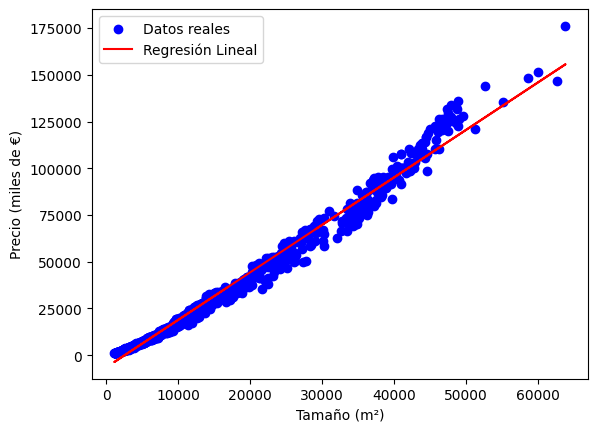

In [26]:
import matplotlib.pyplot as plt

plt.scatter(X, y, color="blue", label="Datos reales")
plt.plot(X, modelo.predict(X), color="red", label="Regresión Lineal")
plt.xlabel("Tamaño (m²)")
plt.ylabel("Precio (miles de €)")
plt.legend()
plt.show()